# Prerequisities and Configuration

In [1]:
from abc import ABC, abstractmethod
from PIL import Image 
import glob
import numpy as np
import os
from cv2 import resize
from PIL import Image
from matplotlib import pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = {
    "data_path": "../input/traffic-sign-dataset-classification/traffic_Data/DATA",
    "img_size": (224,224),
    "img_extension": "png",
    "device": "cuda" if torch.cuda.is_available() else "mps",
    "train_percentage":90,
    "batch_size":256,
    "learning_rate":0.01,
    "num_epochs":5,
    "numpy_seed":22,
    "torch_seed":30,
}

To maintain reproducability, we manually set random feeds for Numpy and Pytorch

In [3]:
np.random.seed(config["numpy_seed"])
torch.manual_seed(config["torch_seed"])

We should specify the parameters of our attack.

In [5]:
attack_params = {
    "return_nodes":{"classifier.5":"classifier.5"},
    "feature_layer":"classifier.5",
    "source_class":0,
    "target_class":1,
    "num_poisons":50,
    "max_iterations":5,
    "learning_rate":1e-5,
    "trigger_size":(30,30),
    "lr_decay_step":500,
    "lr_decay":0.9,
    "num_epochs":1000,
    "max_dist":48/255.0,
    "min_loss":0.1,
    "num_test_poisons":50, 
}
# attack_params = {
#     "return_nodes":{"classifier.5":"classifier.5"},
#     "feature_layer":"classifier.5",
#     "source_class":0,
#     "target_class":1,
#     "num_poisons":50,
#     "max_iterations":2,
#     "learning_rate":1e-5,
#     "trigger_size":(30,30),
#     "lr_decay_step":500,
#     "lr_decay":0.9,
#     "num_epochs":10,
#     "max_dist":48/255.0,
#     "min_loss":0.1,
#     "num_test_poisons":50,  
# }

We need a class to load the images from the folder they're located in

In [6]:
class DataHandler(ABC):
    def __init__(self, data_path, extension):
        self.data_path = data_path
        self.extension = extension
        self.data = None
        self.file_paths = []
        
    @abstractmethod
    def load_data(self):
        pass
    
class ImageHandler(DataHandler):
    def __init__(self, data_path, extension):
        super().__init__(data_path, extension)
        
    def load_data(self):
        print_offset = 10
        self.data = []
        
        for root, dirs, files in os.walk(self.data_path):
            for filename in files:
                if filename.endswith(self.extension):
                    file_path = root + "/" + filename
                    print("\r Now Loading {}".format(file_path), end=' ' * print_offset)
                    self.file_paths.append(file_path)
                    img = np.array(Image.open(file_path))
                    self.data.append(img)
        print('\n Data Loaded')
    
    def resize_images(self, size):
        self.data = [resize(img, size) for img in self.data]
        self.data = np.array(self.data)

# Data Poisoning

In [7]:
class DataPoisoningAttacker(ABC):
    def __init__(self, dataset, model, attack_type):
        self.dataset = dataset
        self.model = model
        self.attack_type = attack_type
        
    @abstractmethod
    def attack(self):
        pass

In [9]:
class OptimizationModel(nn.Module):
    """
        We are using Pytorch as a tool for solving our optimization problem
    """
    
    def __init__(self, feature_extractor, layer_name, target_images):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.layer_name = layer_name
        self.poison_images = nn.Parameter(torch.Tensor(target_images))
        
    def forward(self, patched_source_images):
        num_poisons = patched_source_images.shape[0]
        difference = self.feature_extractor(self.poison_images)[self.layer_name] - self.feature_extractor(patched_source_images)[self.layer_name]
        diff_squared = difference ** 2
        loss = diff_squared.sum() / num_poisons
        return loss

In [12]:
class HiddenBackdoorAttacker(DataPoisoningAttacker):
    """
        Implements Hidden Backdoor Attack proposed by Saha et al. (2020)
    """
    def __init__(self, dataset, model, feature_extractor, layer_name, device):
        super().__init__(dataset, model, "Hidden Backdoor")
        self.trigger = None
        self.feature_extractor = feature_extractor
        self.layer_name = layer_name
        self.device = device
        
    def sample_from_class(self, cls_name, num_samples):
        cls_indices = [idx for idx, label in enumerate(self.dataset["y"]) if label == cls_name]
        chosen_indices = np.random.choice(cls_indices, num_samples, replace=False)
        chosen_x, chosen_y = self.dataset["x"][chosen_indices], self.dataset["y"][chosen_indices]
        return chosen_x, chosen_y
    
    def generate_trigger(self, trigger_size = (30, 30), max_value = 1):
        trigger = np.random.rand(4,4,3)
        trigger = resize(trigger, trigger_size)
        if max_value != 1:
            trigger *= max_value
        self.trigger = trigger
    
    def patch_samples(self, samples):
        """
            - samples: a numpy array of images
        """
        img_width, img_height = self.dataset["x"][0].shape[0] , self.dataset["x"][0].shape[1]
        trigger_width, trigger_height = self.trigger.shape[0], self.trigger.shape[1]
        patched_samples = samples.copy()
        for idx, _ in enumerate(patched_samples):
            pos_x, pos_y = np.random.randint(0, img_width - trigger_width), np.random.randint(0, img_height - trigger_height)
            patched_samples[idx][pos_x:pos_x + trigger_width, pos_y:pos_y + trigger_height, :] = self.trigger
        return patched_samples
    
    def perform_gradient_descent(self, source_samples, target_samples, learning_rate, lr_decay_step, lr_decay, num_epochs):
        model = OptimizationModel(self.feature_extractor, self.layer_name, target_samples.transpose(0, 3, 1, 2))
        model = model.to(self.device)
        opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=lr_decay_step, gamma=lr_decay)
        for i in range(num_epochs):
            loss = model(torch.Tensor(source_samples.transpose(0, 3, 1, 2)).to(self.device))
            loss.backward()
            opt.step()
            opt.zero_grad()
            lr_scheduler.step()
            print(f'\r epoch {i} - loss: {loss}', end='')
        return loss, model.poison_images
    
    def project_onto(self, poison_images, target_images, max_dist):
        one_tensor = torch.ones_like(torch.Tensor(target_images)).to(self.device)
        poison_images = poison_images.permute(0, 2, 3, 1)
        projected_images = torch.clamp(poison_images,
                                       min=torch.Tensor(target_images).to(self.device) - one_tensor * max_dist,
                                       max=torch.Tensor(target_images).to(self.device) + one_tensor * max_dist)\
            .cpu().detach().numpy()
        return projected_images
    
    def attack(self, source_class, target_class, num_poisons, max_iterations, learning_rate, trigger_size, lr_decay_step, lr_decay, num_epochs, max_dist, min_loss=0.1):
        target_samples = self.sample_from_class(target_class, num_poisons)
        target_samples_images = target_samples[0]
        self.generate_trigger(trigger_size)
        loss = 10000000
        iteration_count = 0
        history = {}
        while loss > min_loss and iteration_count <= max_iterations:
            source_samples = self.sample_from_class(source_class, num_samples=num_poisons)
            source_samples_images = source_samples[0]
            patched_source_samples = self.patch_samples(source_samples_images)
            permuted_target_samples = np.random.permutation(target_samples_images)
            loss, poison_images = self.perform_gradient_descent(patched_source_samples,
                                                                permuted_target_samples,
                                                                learning_rate, lr_decay_step,
                                                                lr_decay, num_epochs)
            projected_poison_images = poison_images
            projected_poison_images = self.project_onto(poison_images, permuted_target_samples, max_dist)
            iteration_count += 1
            history[iteration_count] = {"loss": loss, "poison_images": projected_poison_images,
                                        "patched_source_images":patched_source_samples,
                                        "target_images": permuted_target_samples}
        self.history = history
        return self.history[min(history.keys(), key=lambda x: history[x]['loss'])]
        

First, we load the dataset.

In [13]:
handler = ImageHandler(config["data_path"], config["img_extension"])
handler.load_data()

 Now Loading ../input/traffic-sign-dataset-classification/traffic_Data/DATA/24/024_1_0019.png              
 Data Loaded


The images of the dataset are of different shapes. We need to resize all of them.

In [14]:
handler.resize_images((224, 224))

In [15]:
handler.data.shape

(4170, 224, 224, 3)

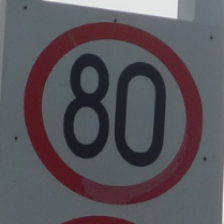

In [16]:
img = Image.fromarray(handler.data[0])
img

The images are located inside folders named after their corresponding class.

In [17]:
data_labels = []
path_prefix = "../input/traffic-sign-dataset-classification/traffic_Data/DATA/"
for idx, fp in enumerate(handler.file_paths):
    tmp_string = fp.replace(path_prefix, "").replace(".png", "")
    label = tmp_string.split("/")[0]
    data_labels.append(int(label))
data_labels = np.array(data_labels)

Let's see how many images we have for each class

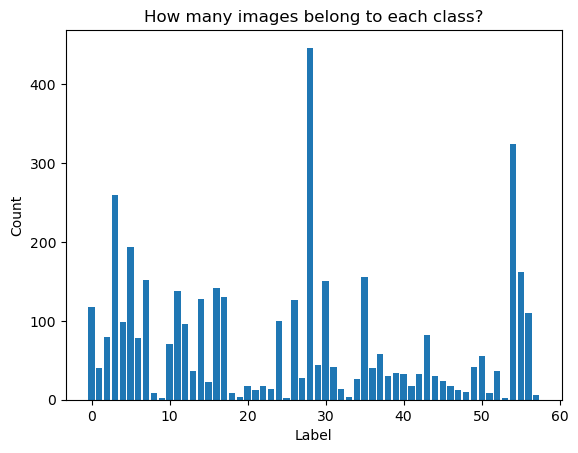

In [18]:
label_count = Counter()
for label in data_labels:
    label_count[label] += 1

plt.bar(label_count.keys(), label_count.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('How many images belong to each class?')
plt.show()

Since the classes 54 and 28 are the most frequent ones, we only use them for our attack.

In [19]:
print(f"class 28 has {label_count[28]} samples and class 54 has {label_count[54]} samples")

class 28 has 446 samples and class 54 has 324 samples


The number of the samples for these classes do not match. In other words, the data is not balanced. Therefore, we need to balance the data. For this purpose, we randomly take 300 images from each class.
Finally, we convert the labels 28 and 54 to 0 and 1, respectively.

In [20]:
te_samples_idx = [idx for idx, label in enumerate(data_labels) if label==28]
ff_samples_idx = [idx for idx, label in enumerate(data_labels) if label==54]
te_samples_idx = np.random.choice(te_samples_idx, 300, replace=False)
ff_samples_idx = np.random.choice(ff_samples_idx, 300, replace=False)
te_x, ff_x = handler.data[te_samples_idx], handler.data[ff_samples_idx]
te_y, ff_y = data_labels[te_samples_idx], data_labels[ff_samples_idx]
x = np.concatenate((te_x, ff_x), axis=0)
y = np.concatenate((te_y, ff_y), axis=0)
label_converter = lambda x: 0 if x == 28 else 1
y = np.vectorize(label_converter)(y)

In [ ]:
x.shape

In [ ]:
y.shape

In [21]:
np.unique(y)

array([0, 1])

Now we change the range of the pixel values in a way that each pixel value is between 0 and 1.

In [22]:
x_tmp = x / 255.0
y_tmp = y.copy()

In [23]:
x_train, x_rem, y_train, y_rem = train_test_split(x_tmp, y_tmp, test_size=1-config["train_percentage"]/100, random_state=50)
x_test, x_dev, y_test, y_dev = train_test_split(x_rem, y_rem, test_size=0.5, random_state=50)

In [24]:
del x_tmp, y_tmp

# Loading the Feature Extractor (Alexnet)

In [25]:
model = models.alexnet(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 81.2MB/s] 


We should fix the weights of the model so that the feature extractor does not change during the training process.

In [26]:
for param in model.parameters():
    param.requires_grad = False

We need to make a "feature extractor" object from this model

In [27]:
feature_ext = create_feature_extractor(model, return_nodes=attack_params["return_nodes"])

In [28]:
def feature_extractor(x: torch.Tensor):
  return feature_ext(torch.Tensor(x.transpose(0,3,1,2)))[attack_params["feature_layer"]]

# Launching the Attack

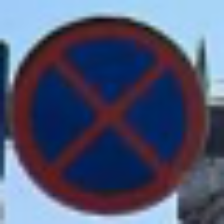

In [29]:
Image.fromarray((x_train[0]*255).astype('uint8'))

In [30]:
attacker = HiddenBackdoorAttacker({"x": x_train, "y": y_train}, model, feature_ext,
                                  attack_params["feature_layer"], config["device"])

In [31]:
best_attack = attacker.attack(source_class=attack_params["source_class"],
                          target_class=attack_params["target_class"],
                          num_poisons=attack_params["num_poisons"],
                          max_iterations=attack_params["max_iterations"],
                          learning_rate=attack_params["learning_rate"],
                          trigger_size=attack_params["trigger_size"],
                          lr_decay_step=attack_params["lr_decay_step"],
                          lr_decay=attack_params["lr_decay"],
                          num_epochs=attack_params["num_epochs"],
                          max_dist=attack_params["max_dist"],
                          min_loss=attack_params["min_loss"])

 epoch 999 - loss: 4328.613281253755

We also need to patch some of the testing images. They will be useful for evaluating the attack.

In [32]:
idx_lst = [i for i in range(x_test.shape[0])]
chosen_idx_lst = np.random.choice(idx_lst, attack_params["num_test_poisons"], replace=True)
x_test_chosen = x_test[chosen_idx_lst]
x_test_poisoned = attacker.patch_samples(x_test_chosen)
y_test_poisoned = np.ones(attack_params["num_test_poisons"])
x_test = np.concatenate((x_test, x_test_poisoned), axis=0)
y_test = np.concatenate((y_test, y_test_poisoned), axis=0)

In [33]:
print(f"best attack loss was {best_attack['loss']}")

best attack loss was 4201.603515625


One of the target images:

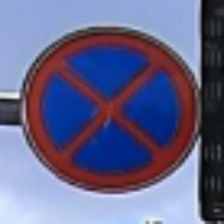

In [34]:
Image.fromarray((best_attack['target_images'][0]*255).astype('uint8'))

One of the generated poisons corresponding to the target image:

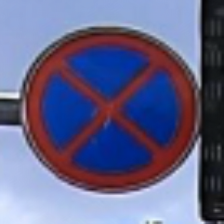

In [35]:
Image.fromarray((best_attack['poison_images'][0]*255).astype('uint8'))

The patched source image corresponding to the target image:

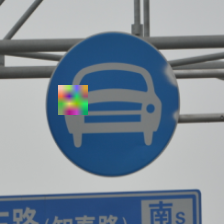

In [36]:
Image.fromarray((best_attack['patched_source_images'][0]*255).astype('uint8'))

Are the poison image and the target image the same?

In [37]:
np.abs(best_attack['poison_images'][0] - best_attack['target_images'][0]).max()

0.007632329855479444

Are the poison image and the patched source image close in the feature space?

In [38]:
def feature_extractor(x: torch.Tensor):
  return feature_ext(torch.Tensor(x.permute(0,3,1,2)))[attack_params["feature_layer"]]

In [39]:
tmp_target = torch.Tensor(best_attack['target_images'][0].reshape(1,224,224,3)).to(config['device'])
target_fs = feature_extractor(tmp_target)

In [40]:
tmp_poison = torch.Tensor(best_attack['poison_images'][0].reshape(1,224,224,3)).to(config['device'])
poison_fs = feature_extractor(tmp_poison)

In [41]:
((target_fs - poison_fs)**2).sum().cpu().detach().numpy()

array(1349.3224, dtype=float32)

Now that we have the poisoned images, we should add them to the training set.

In [42]:
poisoned_images = best_attack["poison_images"]

In [43]:
poisoned_images.shape

(50, 224, 224, 3)

In [44]:
poisoned_labels = np.array([attack_params["target_class"] for i in range(attack_params["num_poisons"])])
x_train_poisoned = np.concatenate((x_train, poisoned_images), axis=0)
y_train_poisoned = np.concatenate((y_train, poisoned_labels), axis=0)

In [45]:
is_poison_train = np.array([0 for i in range(x_train.shape[0])] + [1 for i in range(attack_params["num_poisons"])])
is_poison_dev = np.array([0 for i in range(x_dev.shape[0])])
is_poison_test = np.array([0 for i in range(x_test.shape[0])])
is_poison_test[-(attack_params["num_test_poisons"]):] = 1

In [46]:
with open('/kaggle/working/x-train.npy', 'wb') as f:
    np.save(f, x_train_poisoned)
with open('/kaggle/working/y-train.npy', 'wb') as f:
    np.save(f, y_train_poisoned)
with open('/kaggle/working/x-test.npy', 'wb') as f:
    np.save(f, x_test)
with open('/kaggle/working/y-test.npy', 'wb') as f:
    np.save(f, y_test)
with open('/kaggle/working/x-dev.npy', 'wb') as f:
    np.save(f, x_dev)
with open('/kaggle/working/y-dev.npy', 'wb') as f:
    np.save(f, y_dev)
with open('/kaggle/working/is-poison-train.npy', 'wb') as f:
    np.save(f, is_poison_train)
with open('/kaggle/working/is-poison-dev.npy', 'wb') as f:
    np.save(f, is_poison_dev)
with open('/kaggle/working/is-poison-test.npy', 'wb') as f:
    np.save(f, is_poison_test)